### Hypothesis: CA1 performs probabilistic inference on the stimulus to infer current place in position x morph space

Posterior probability of the true stimulus, $S$ , given the animals observation, $\hat{S}$ , is $P(S|\hat{S}) \propto P(\hat{S}|S)P(S)$ (Bayes Rule),
where $P(\hat{S}|S)$ is the likelihood of an observation given the stimulus (aka noisy estimate of the stimulus), and $P(S)$ is the prior over the stimuli.


All we're going to do is change the prior and see what happens to the $MAP$ estimate

In [1]:
import numpy as np
import scipy as sp
import scipy.ndimage.filters as filters
from scipy.interpolate import interp1d as spline
import os

from matplotlib import pyplot as plt

%matplotlib inline


In [2]:
# preliminaries - make general purpose functions
gaussian = lambda mu,sigma,x: np.exp(-(mu-x)**2/sigma**2)
unif = lambda mu, sigma, x: 1*(np.abs(x-mu)<=sigma/2)

def gaussian_dens(mu,sigma,x):
    v = gaussian(mu,sigma,x)
    return v/v.sum()

def mult_and_norm(dens1,dens2):
    post = dens1*dens2
    return post/post.sum()


The results look like the mouse perceives the stimulus on the log scale, so I am going to do a correction of the sampled morph values to this space to show that this is a better match to the data

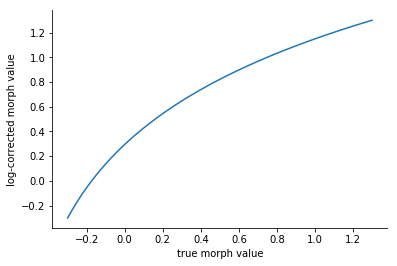

In [3]:
# demonstrating that the log scale of the stimulu is not a linear function of the morph value
# theta = np.linspace(-.3,1.3,num=200) # possible morph values
# f1,f2 = 4, 12 # actual frequencies the mouse sees

# mm = np.log10(f1*(1-theta) + f2*(theta)) # log of the linear combinations of the stimuli

theta = np.linspace(-.1,1.1,num=200) # possible morph values
f1,f2 = .2,.8 # light dark 

__mm = np.log(f1*(1-theta) + f2*(theta)) # log of the linear combinations of the stimuli
f1,f2 = 3,12 # actual frequencies the mouse sees
_mm = np.log(f1*(1-theta) + f2*(theta))
mm = (__mm+ _mm)/2 # log of the linear combinations of the stimuli


# scale this so it's back in the range of the morph values without distortion
theta_corrected = (mm-np.amin(mm))/(np.amax(mm)-np.amin(mm))*1.6 - .3 
theta_corrected[0],theta_corrected[-1]=-.3,1.3 # hard code the edges to correct float errors
theta = np.linspace(-.3,1.3,num=200)
# splines for going between the two spaces
morph_2_logstim = spline(theta,theta_corrected)
logstim_2_morph = spline(theta_corrected,theta)

f,ax = plt.subplots()
ax.plot(theta,theta_corrected)
ax.set_xlabel('true morph value')
ax.set_ylabel('log-corrected morph value')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [4]:
def run_posterior_inference(p_theta,samp=np.linspace(-.3,1.3,num=1000),color='black'):
    '''function runs probabilistic inference and makes a few helpful plots
    Inputs: p_theta - the stimulus prior in log-space sampled at the values of previously defined theta
    Returns: figure and axes handles'''
    
    samp_mask = (samp>=-.3) & (samp<=1.3)
    ### RUN SOME DEMOS OF WHAT THE INFERENCE PROCESS LOOKS LIKE AT DIFFERENT STIMULUS VALUES
    
    # likelihood - zero centered gaussian with fixed variance in log space
    p_s_theta = gaussian_dens(morph_2_logstim(0),.2,samp)

    # posterior - multiply likelihood and posterior and normalize to be a valid distribution
    p_theta_s = mult_and_norm(p_s_theta,p_theta)

    f_post_demo,ax_post_demo = plt.subplots(1,5,figsize=[15,3])
    ax_post_demo[0].plot(samp,p_theta,label='prior',color='red')
    ax_post_demo[0].plot(samp,p_s_theta,label='likelihood',alpha=.4,color='blue')
    ax_post_demo[0].plot(samp,p_theta_s,label='posterior',color='green')
    
    ax_post_demo[0].spines['right'].set_visible(False)
    ax_post_demo[0].spines['top'].set_visible(False)
    ax_post_demo[0].set_yticks([])
    ax_post_demo[0].set_ylabel('$P$')
    ax_post_demo[0].set_xlabel('$S$')
    ax_post_demo[0].set_title("$\hat{S} =$ 0")
#     ax_post_demo[0].set_ylim([0,.05])
    # repeat above for a few other stimulus values
    for i,s in enumerate(morph_2_logstim(np.array([.25,.5,.75,1]))):
        # likelihood 
        p_s_theta = gaussian_dens(s,.2,samp)

        # posterior 
        p_theta_s = mult_and_norm(p_s_theta,p_theta)


        ax_post_demo[i+1].plot(samp[samp_mask],p_theta[samp_mask],label='prior',color='red')
        ax_post_demo[i+1].plot(samp[samp_mask],p_s_theta[samp_mask],label='likelihood',alpha=.4,color='blue')
        ax_post_demo[i+1].plot(samp[samp_mask],p_theta_s[samp_mask],label='posterior',color='green')
        ax_post_demo[i+1].spines['right'].set_visible(False)
        ax_post_demo[i+1].spines['top'].set_visible(False)
        ax_post_demo[i+1].set_yticks([])
        ax_post_demo[i+1].set_title("$\hat{S} =$ %.2f" % logstim_2_morph(s) )
#         ax_post_demo[i+1].set_ylim([0,.05])

    ax_post_demo[-1].legend()
    ### CALCULATE POSTERIOR AT RANGE OF STIMULUS VALUES AND PLOT
        
    f_post_dens,ax_post_dens = plt.subplots()
    ax_post_dens.spines['right'].set_visible(False)
    ax_post_dens.spines['top'].set_visible(False)
    theta_hat=[] # keep track of MAP estimate
    theta_hat_var = []
    p_shat = [] # posterior at current value of stimulus
   
    for i,s in enumerate(theta): # sample log-spaced values
        p_s_theta = gaussian_dens(s,.3,samp) # likelihood
        p_theta_s = mult_and_norm(p_s_theta,p_theta) # posterior
        
        
        ax_post_dens.plot(logstim_2_morph(samp),p_theta_s,color=plt.cm.cool(1-i/100.)) # convert back from logspace
        theta_hat.append(samp[np.argmax(p_theta_s)]) # MAP estimate
        mu = (samp*p_theta_s).sum()#*(samp[1]-samp[0])/samp.shape[0]
        theta_hat_var.append((((samp-mu)**2)*p_theta_s).sum())
        p_shat.append((p_s_theta*p_theta).sum())

    ax_post_dens.set_ylabel('$P$')
    ax_post_dens.set_xlabel('$S$')
    ax_post_dens.set_title('Posterior density for different stimulus values')

    ## PLOT MAP ESTIMATE
    f_MAP,ax_MAP = plt.subplots(1,2,figsize=[10,3])
    f_MAP.subplots_adjust(wspace=.5)
    ax_MAP[0].spines['right'].set_visible(False)
    ax_MAP[0].spines['top'].set_visible(False)
    ax_MAP[0].scatter(logstim_2_morph(theta),logstim_2_morph(np.array(theta_hat)),color=color)
    ax_MAP[0].set_ylim([1.2,-.2])
    ax_MAP[0].set_ylabel('$S_{MAP}$')
    ax_MAP[0].set_xlabel('$S$')
    
    ax_MAP[1].spines['right'].set_visible(False)
    ax_MAP[1].spines['top'].set_visible(False)
    ax_MAP[1].scatter(logstim_2_morph(theta),np.array(theta_hat),color=color)
    ax_MAP[1].set_ylim([1.3,-0.3])
    ax_MAP[1].set_ylabel('log-corrected $S_{MAP}$')
    ax_MAP[1].set_xlabel('$S$')
    
    return np.array(theta_hat),np.array(theta_hat_var),(f_post_demo,ax_post_demo),(f_post_dens,ax_post_dens),(f_MAP,ax_MAP)


def convert_prior_to_log(prior,samp = np.linspace(-.3,1.3,num=1000)):
    '''convert a prior distribution in stimulus space to logspace for proper sampling
    Input: prior - arbitrary distribution assumed to be sampled in the range of values of theta variable
    Returns: log_dens - log space density for use with run_posterior_inference
             log_sampling_spline - log space cummulative distribution spline for sampling with kWTA_network_model (defined below)'''
    samp_mask = (samp>=-.3) & (samp<=1.3)
    # normalize to ensure prior is a proper distribution
    prior = np.convolve(prior,gaussian(.5,.1,samp),mode='same')
    prior/=prior.sum()
    # go to cummulative distribution so that conversion maintains density
    cum_prior = np.cumsum(prior)
    cum_prior[0],cum_prior[-1] = 0,1 # correct for float errors
    cum_spline = spline(samp,cum_prior) # fit a linear interpolation spline so that we can arbitrarily sample
    log_cum_spline = spline(morph_2_logstim(samp),cum_prior)
    log_cum = log_cum_spline(samp) # sample cummulative distribution in log space
    log_sampling_spline = spline(cum_prior,morph_2_logstim(samp))  # create transposed spline for sampling values according to their probability
    
    f,ax = plt.subplots(1,2)
    
    
    for a in range(2):
        ax[a].spines['right'].set_visible(False)
        ax[a].spines['top'].set_visible(False)
        
    ax[0].plot(samp[samp_mask],cum_prior[samp_mask],label='morph space',color='black')
    ax[0].plot(morph_2_logstim(samp[samp_mask]),cum_prior[samp_mask],label='log space',color='red')
    ax[0].legend()
    ax[0].set_ylabel('$F(S)$')
    ax[0].set_xlabel('$S$')
    
    ax[1].plot(samp[samp_mask],prior[samp_mask],color='black')
    #convert cumulative density back to density
    log_dens = log_cum[1:]-log_cum[:-1]
    log_dens[:10]= log_dens[10] # stretching at the end of the spline causes artifacts so we're just clamping those values 
    log_dens = np.append(log_dens,log_dens[-1])
    log_dens /=log_dens.sum()
    ax[1].plot(morph_2_logstim(samp[samp_mask]),log_dens[samp_mask],color='red')
    ax[1].set_ylabel('$P(S)$')
    ax[1].set_xlabel('$S$')
    ax[1].set_yticks([])
#     ax[1].set_ylim([0,.05])
    
    return log_dens, log_sampling_spline, (f,ax)


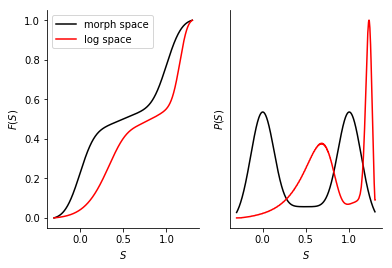

In [5]:
### BUILD PRIOR

# setup Rare Morph prior in logspace as a Gaussian mixture with means at 0 and 1
samp = np.linspace(-.3,1.3,num=1000)
dens = unif(0,.2,samp)+unif(1,.2,samp)+1E-1
f = unif(.5,.2,samp)
rare_prior = np.convolve(np.convolve(dens,f,mode='same'),f,mode='same')
rare_prior = rare_prior/rare_prior.sum()


rare_log_dens, rare_lcs,fig = convert_prior_to_log(rare_prior)


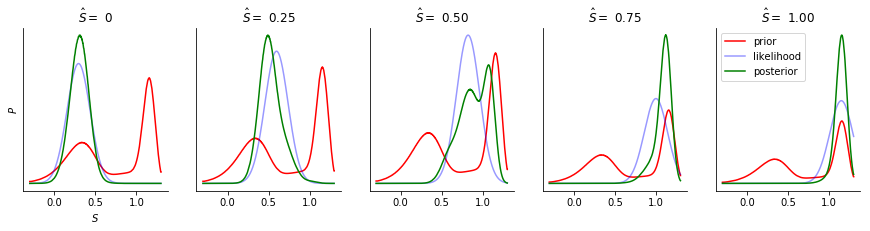

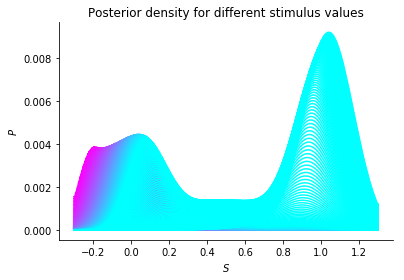

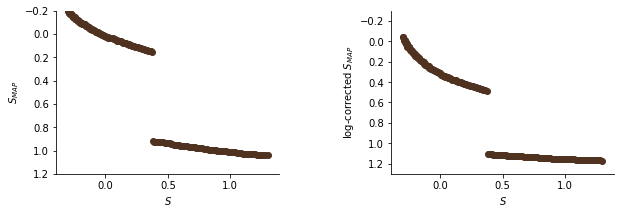

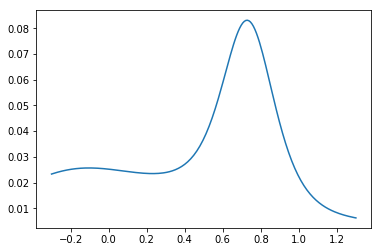

In [6]:
# RUN INFERENCE

rare_p_shat, rare_p_shat_var,(f_post_demo,ax_post_demo),(f_post_dens,ax_post_dens),(f_MAP,ax_MAP) = run_posterior_inference(rare_log_dens,color=plt.cm.copper(.25))
f,ax = plt.subplots()
ax.plot(theta,rare_p_shat_var)

## Frequent Morph Prior Bayesian Inference
Prior is uniform in the true morph space (not uniform in log space)

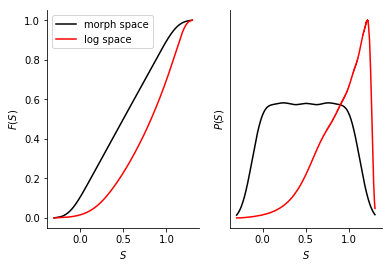

In [8]:
# setup prior in logspace
dens = unif(0,.2,samp)+unif(.25,.2,samp) + unif(.5,.2,samp) + unif(.75,.2,samp) + unif(1,.2,samp)+1E-2
f = unif(.5,.2,samp)
fam_prior = np.convolve(np.convolve(dens,f,mode='same'),f,mode='same')
fam_prior =fam_prior/fam_prior.sum()



fam_log_dens, fam_lcs,fig = convert_prior_to_log(fam_prior)


NameError: name 'figdir' is not defined

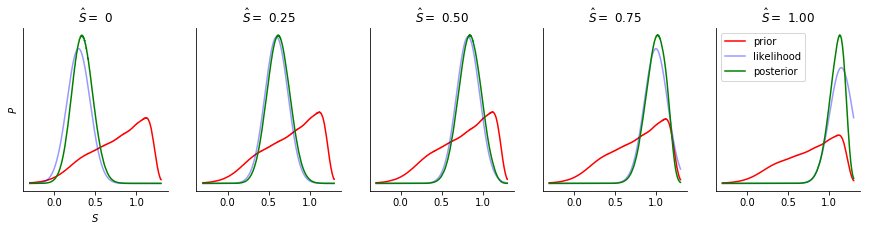

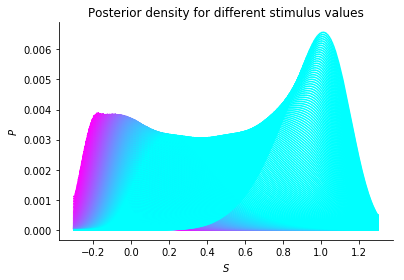

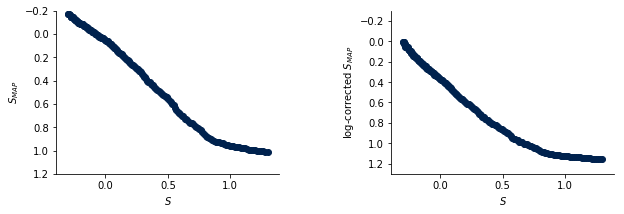

In [9]:
fam_p_shat,fam_p_shat_var,(f_post_demo,ax_post_demo),(f_post_dens,ax_post_dens),(f_MAP,ax_MAP) = run_posterior_inference(fam_log_dens,color=plt.cm.cividis(0.))

f,ax = plt.subplots()
ax.plot(theta,fam_p_shat_var)